### 

This code is designed to train a Spiking Neural Network with Rockpool LIF neurons.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

#!ls drive/MyDrive/
import sys
sys.path.append('/content/drive/MyDrive/Thesis/')

Mounted at /content/drive/


In [2]:
!pip install autoreject
!pip install mne
!pip install rockpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.6/477.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rockpool: filename=rockpool-2.7-py3-none-any.whl size=580115 sha256=bc6213fed9d51444f86122aa1bde2c6eb66202f58f5abecb71bbb841ca9d719e
  Stored in directory: /root/.cache/pip/wheels/37/bd/e5/c23864072446be49aecda6ad04d36cad5d02d7afe5fdc64dde
Successfully built rockpool


In [3]:
# - Basic imports
import torch
import torchvision
import glob
import mne
import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF
from utils import EegData
from bsa import BSA
from poisson import poisson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

### Load dataset, split it in the tasks and create epochs

Each signal has 32 channels X 3200 samples = 25 sec of recording with 128 samples per second (SPS).
Spliting each signals in epochs of duration sec: 32 channels x   samples = duration sec x 128 SPS.
Number of epochs: 40 subjects X 12 trials X 5 epochs = 2400 epochs.

Final dataset: 2400 epochs X 32 channels X 640 samples

In [4]:
# Read EEG data from the figshare dataset
files_path = glob.glob("/content/drive/MyDrive/eeg_dataset/filtered_data/*.mat")
print((files_path[0].split('/')))
#SOURCE_DIR = '/content/drive/My Drive/carseg_data/arrays'

arithmetic_task_files = [i for i in files_path if 'Arithmetic' in i.split('/')[6]]
mirror_image_task_files =[i for i in files_path if 'Mirror_image' in i.split('/')[6]]
relax_files = [i for i in files_path if 'Relax' in i.split('/')[6]]
stroop_task_files =  [i for i in files_path if 'Stroop' in i.split('/')[6]]

print(arithmetic_task_files)
# print(len(arithmetic_task_files), len(mirror_image_task_files), len(relax_files), len(stroop_task_files))
duration = 5
overlap = 3

arithmetic_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in arithmetic_task_files]
mirror_image_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in mirror_image_task_files]
relax_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in relax_files]
stroop_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in stroop_task_files]

data_list = arithmetic_task_epochs + mirror_image_task_epochs + relax_task_epochs + stroop_task_epochs
data_array = np.vstack(data_list)


['', 'content', 'drive', 'MyDrive', 'eeg_dataset', 'filtered_data', 'Arithmetic_sub_10_trial1.mat']
['/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial3.mat', '/conten

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitl

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


In [5]:
print(data_array.shape)
no_repeat = data_array.shape[0]/(12*40)
# no_repeat = (25 - duration) / (duration - overlap) + 1 (if 25 % duration != 0 or overlap != 0)
print(no_repeat)
print(len(data_list))
print(len(arithmetic_task_epochs), len(mirror_image_task_epochs), len(relax_task_epochs), len(stroop_task_epochs))

(5280, 32, 640)
11.0
480
120 120 120 120


Load labels and transform them to binary values ( feedback higher than 5: stressed, lower than 5: relaxed)


array([[<Axes: title={'center': 'sub_'}>,
        <Axes: title={'center': 'Arithmetic_trial1'}>,
        <Axes: title={'center': 'Mirror_image_trial1'}>],
       [<Axes: title={'center': 'Stroop_trial1'}>,
        <Axes: title={'center': 'Arithmetic_trial2'}>,
        <Axes: title={'center': 'Mirror_image_trial2'}>],
       [<Axes: title={'center': 'Stroop_trial2'}>,
        <Axes: title={'center': 'Arithmetic_trial3'}>,
        <Axes: title={'center': 'Mirror_image_trial3'}>],
       [<Axes: title={'center': 'Stroop_trial3'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2880x1080 with 0 Axes>

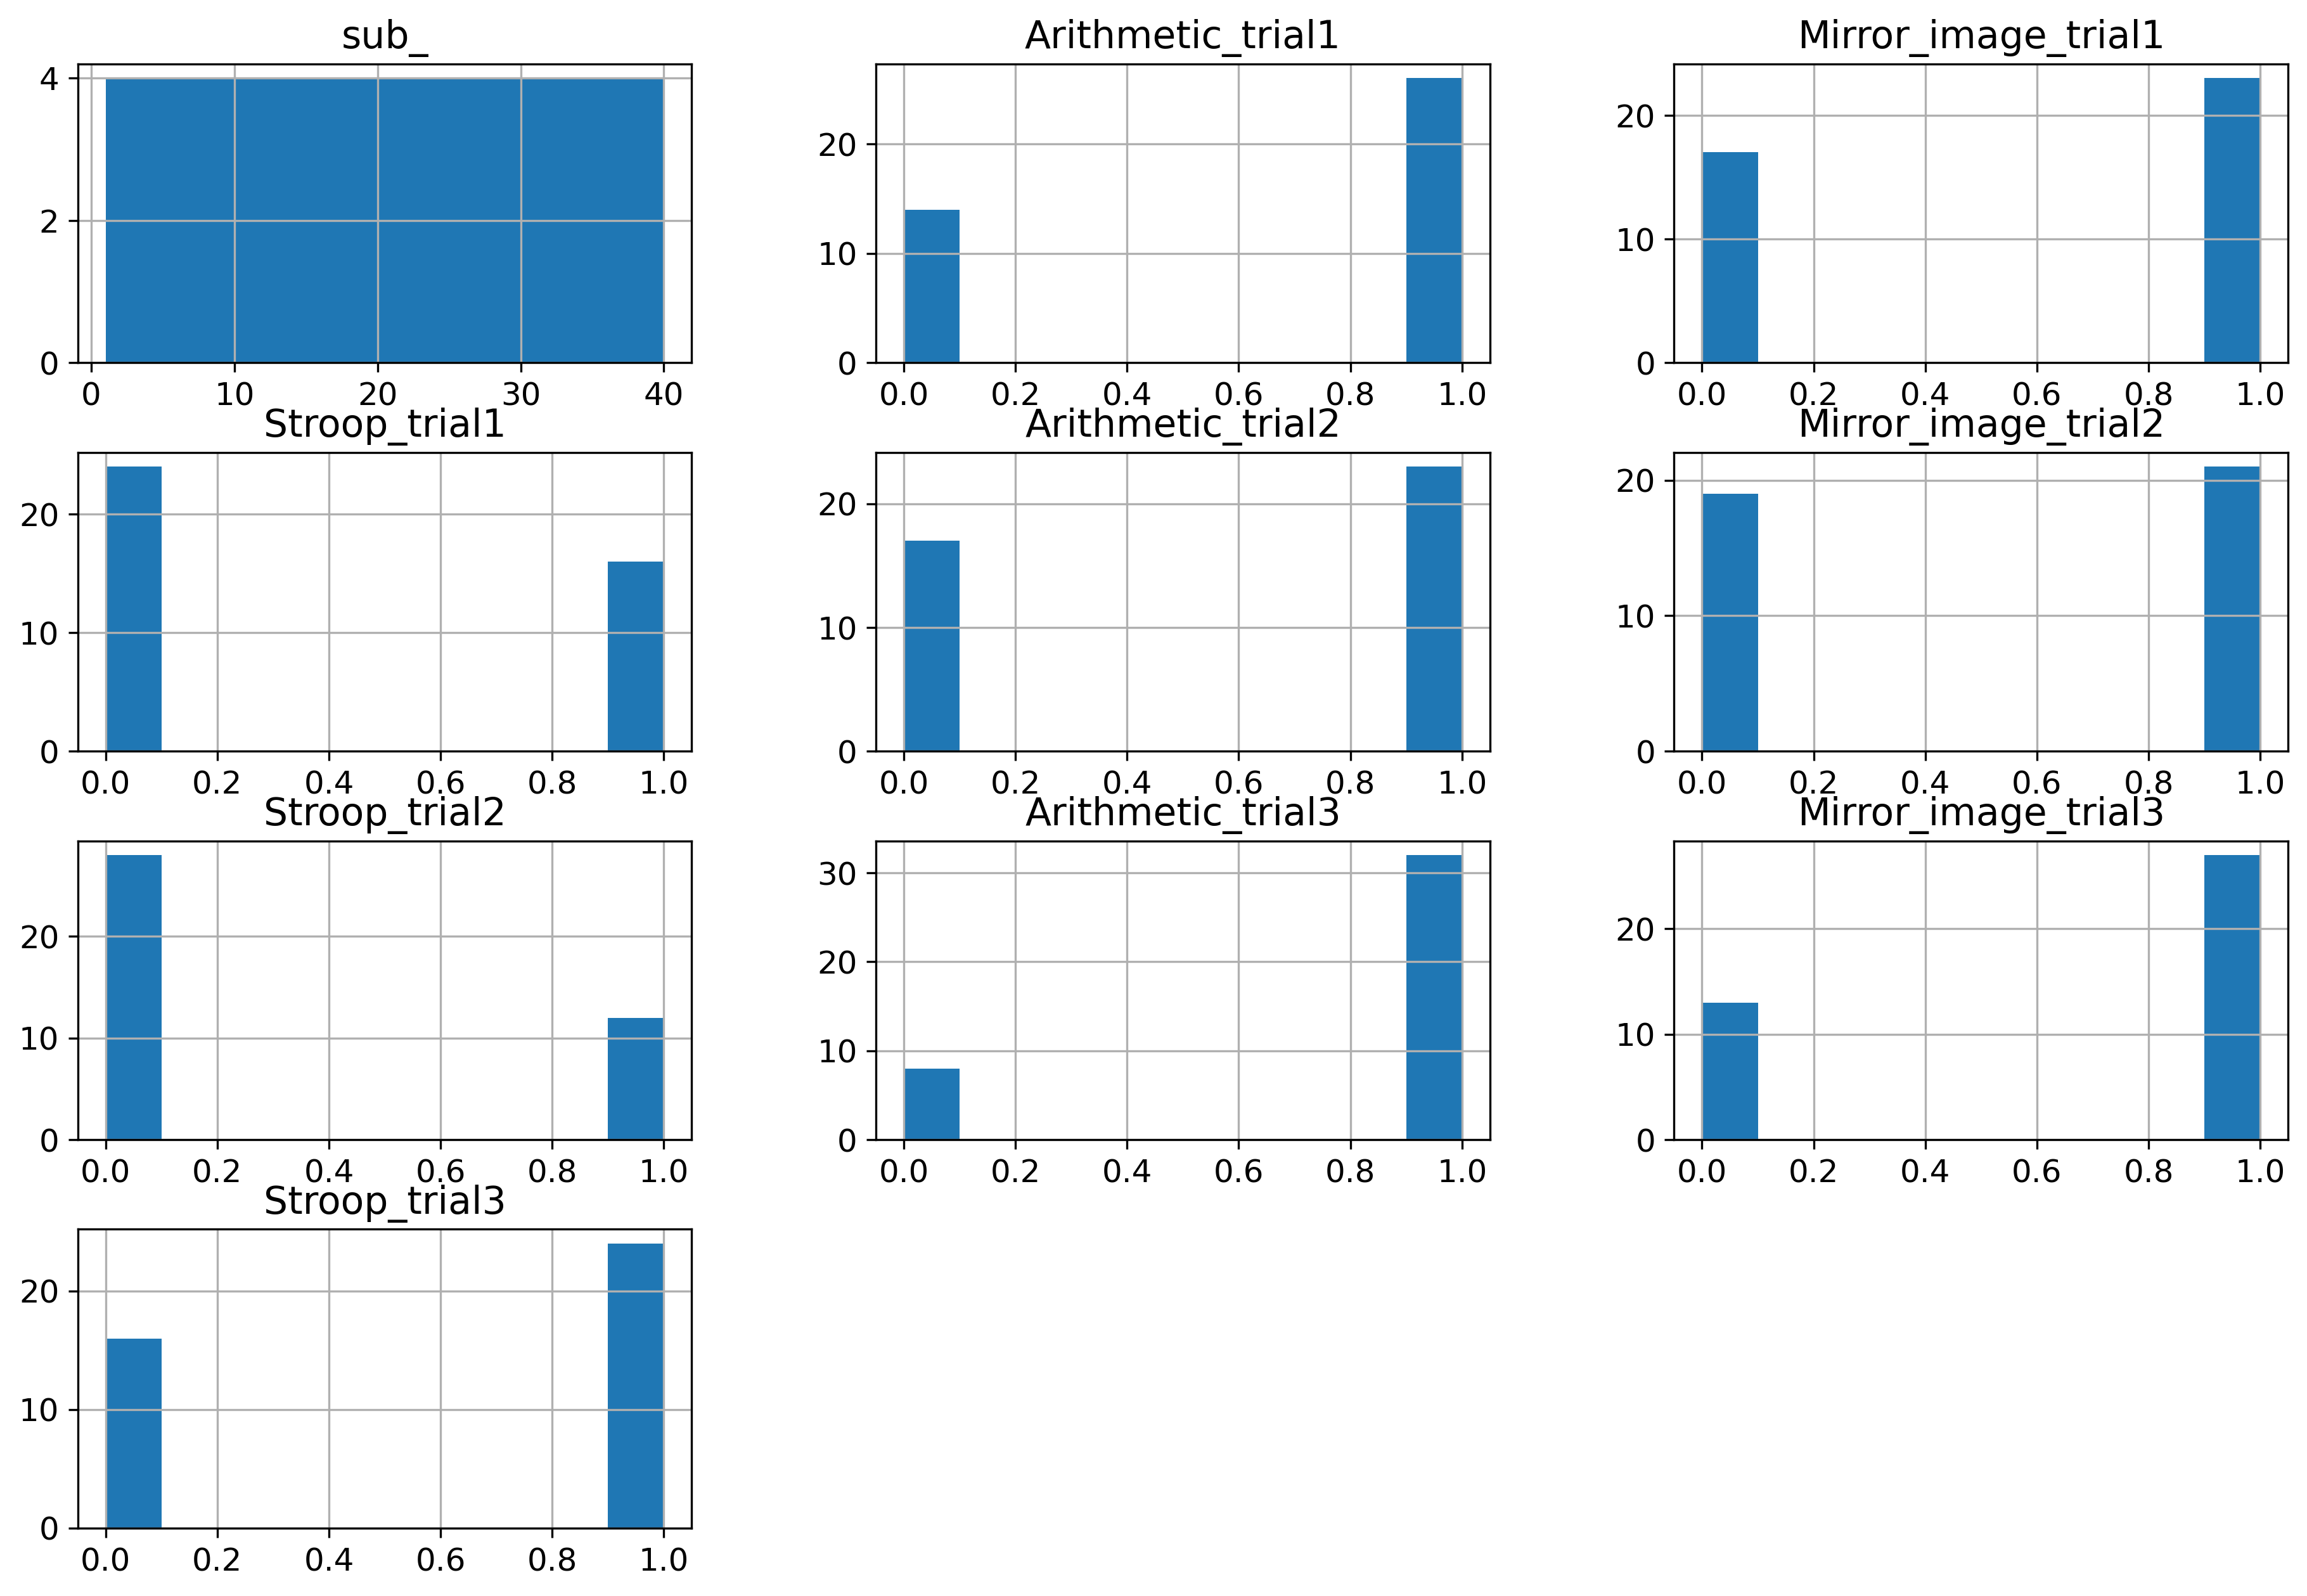

In [6]:
# create labels: 0 - relaxed, 1 - stressed
COLUMNS_TO_RENAME = {
    'Subject No.': 'sub_',
    'Trial_1': 'Arithmetic_trial1',
    'Unnamed: 2': 'Mirror_image_trial1',
    'Unnamed: 3': 'Stroop_trial1',
    'Trial_2': 'Arithmetic_trial2',
    'Unnamed: 5': 'Mirror_image_trial2',
    'Unnamed: 6': 'Stroop_trial2',
    'Trial_3': 'Arithmetic_trial3',
    'Unnamed: 8': 'Mirror_image_trial3',
    'Unnamed: 9': 'Stroop_trial3'
}

def load_labels():
    '''
    Loads labels from the dataset and transforms the label values to binary values.

    Returns:
        ndarray: The labels.
    '''
    labels = pd.read_excel("/content/drive/MyDrive/eeg_dataset/scales.xls")
    labels = labels.rename(columns=COLUMNS_TO_RENAME)
    labels = labels[1:]
    labels.iloc[:, 1:] = labels.iloc[:, 1:] >= 5
    labels = labels.astype("int")
    return labels

labels = load_labels()
plt.figure()
labels.hist(figsize=(15,10))
#print(labels)

In [7]:
# Match data files with the labels values
# file = eeg_dataset/filtered_data\Task_sub_no_trialno.mat
def get_label(path_file):

    # extract only file name from the path_file
    file = os.path.basename(path_file)

    # remove .mat extension
    file = file.split('.')[0]

    # split the file into data frame columns
    split_file = file.split('_')

    # extract line and column from data frame
    line = int(split_file[len(split_file) - 2]) - 1

    # special case for Mirror_image
    if (len(split_file) == 5):
        split_file[0] = split_file[0] + '_' + split_file[1]
    column_name = split_file[0] + "_" + split_file[len(split_file) - 1]

    return labels.iloc[line][str(column_name)]

# extract labels for each task, subject and trial
arithmetic_task_labels = [get_label(i) for i in arithmetic_task_files]
relax_labels = [0 for i in relax_files]
stroop_task_labels =  [get_label(i) for i in stroop_task_files]
mirror_image_task_labels =[get_label(i) for i in mirror_image_task_files]

#repeat the labels for the specified amount of epochs
arithmetic_task_labels = np.array(arithmetic_task_labels).repeat(no_repeat)
relax_labels = np.array(relax_labels).repeat(no_repeat)
stroop_task_labels = np.array(stroop_task_labels).repeat(no_repeat)
mirror_image_task_labels = np.array(mirror_image_task_labels).repeat(no_repeat)

label_array = np.concatenate((arithmetic_task_labels, relax_labels, stroop_task_labels, mirror_image_task_labels))
print(label_array.shape)
#d = {'files': arithmetic_task_files, 'labels': arithmetic_task_labels}
#df = pd.DataFrame(data=d)
#print(df)

(5280,)


In [8]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
            X = torch.as_tensor(X[None, ...])
        return X, y

In [10]:
def encode_batch_data(eeg, num_timesteps, scale=1):
    if (eeg.dim() == 3):
        num_batches, frame_x, frame_y = eeg.shape
    elif (eeg.dim() == 2):
        num_batches, frame_x = eeg.shape
    eeg = scale * eeg.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
    return (torch.rand(eeg.shape) < (eeg * scale)).float()

def encode_data(eeg, num_timesteps):
    eeg_array = np.array(eeg)
    # Select a single channel from the EEG data
    single_channel_data = eeg_array
    # Normalize the data
    max_data = np.max(single_channel_data)
    min_data = np.min(single_channel_data)
    normalized_data = (single_channel_data - min_data) / (max_data - min_data)

    # Encode the EEG data using the Poisson method
    poisson_spikes = poisson.encode(normalized_data, num_timesteps=num_timesteps)
    decoded_poisson_spikes = poisson.decode(poisson_spikes)* (max_data - min_data) + min_data
    return single_channel_data, poisson_spikes, decoded_poisson_spikes

# - Define a function to encode the network target
def encode_class(class_idx, num_classes, num_timesteps, scale = 1):
    num_batches = class_idx.numel()
    # Generate Poisson events

    target = torch.nn.functional.one_hot(class_idx.long(), num_classes = num_classes)
    return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()


Data and encoding

In [11]:
from torch.utils.data import DataLoader, ConcatDataset
# - Create a data loader for the training dataset
x, x_test, y, y_test = train_test_split(data_array, label_array, test_size=0.2, shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.20, random_state=1)

# Create dataloaders
train_batch_size = 32  # Important hyperparameter
valid_batch_size = 32  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

train_set = EpochsDataset(x_train, y_train)
valid_set = EpochsDataset(x_val, y_val)
test_set = EpochsDataset(x_test, y_test)


print('Number of examples in each set:')
print(f'Training: {len(train_set)}')
print(f'Validation: {len(valid_set)}')
print(f'Test: {len(test_set)}')

loader_train = DataLoader(
    train_set, batch_size=train_batch_size, shuffle=False, num_workers=num_workers)
loader_valid = DataLoader(
    valid_set, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_set, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)


Number of examples in each set:
Training: 3379
Validation: 845
Test: 1056


In [13]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_timesteps = 256
num_classes = 2

input_channels = torch.from_numpy(train_set[0][0]).numel()

num_hidden1 = 512
num_hidden2 = 64
tau_mem = Constant(2e-2)
tau_syn = Constant(5e-3)
threshold = Constant(0.6)
threshold2 = Constant(0.4)
threshold3 = Constant(0.15)
bias = Constant(0.1)

# - Define the temporal aspects of a data sample
dt = 10e-3
# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden1)),
    LIFTorch(num_hidden1, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden1, num_hidden2)),
    LIFTorch(num_hidden2, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold2, bias = bias, dt = dt),

    LinearTorch((num_hidden2, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold3, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (20480, 2) {
    LinearTorch '0_LinearTorch' with shape (20480, 512)
    LIFTorch '1_LIFTorch' with shape (512, 512)
    LinearTorch '2_LinearTorch' with shape (512, 64)
    LIFTorch '3_LIFTorch' with shape (64, 64)
    LinearTorch '4_LinearTorch' with shape (64, 2)
    LIFTorch '5_LIFTorch' with shape (2, 2)
}


In [15]:
from torch.optim.adam import Adam

# - Initialise the optimizer with the network parameters
optimizer = Adam(snn.parameters().astorch(), lr=1e-4)

In [16]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cpu


In [17]:
from sklearn.metrics import accuracy_score

def train(model, device, train_loader, optimizer):
  # - Prepare model for training
  model.train()
  losses = []
  correct = 0
  train_loss = np.zeros(len(train_loader))
  y_pred_all, y_true_all = list(), list()

  # - Loop over the dataset for this epoch
  for idx_batch, (data, class_idx) in enumerate(tqdm(train_loader, leave=False, desc='Training', unit='batch')):
    # - Encode input and target
    data = encode_batch_data(data, num_timesteps)

    target = encode_class(class_idx, num_classes, num_timesteps)
    # print(target.shape)
    # - Zero gradients, simulate model
    optimizer.zero_grad()
    output, _, _ = model(data.to(device))
    #print(output.shape)

    # - Compute MSE loss and perform backward pass
    loss = torch.nn.functional.mse_loss(output, target.to(device))
    loss.backward()
    optimizer.step()

    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(target.cpu().numpy())

    train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    #perf = balanced_accuracy_score(y_true, y_pred)

    # - Compute loss and prediction
    pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
    correct += pred.eq(class_idx.view_as(pred)).sum().item()

    # - Keep track of the losses
    losses.append(loss.item())

  acc = 100.0 * correct / len(train_loader.dataset)

  return losses, np.mean(train_loss), acc

In [18]:
def test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        data = encode_batch_data(data, num_timesteps, scale=1)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(data.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [19]:
# - Initial loss and accuracy
test_loss, test_acc = test(snn.to(device), device, loader_test)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%')

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

Initial test loss 0.015625, accuracy 57.00757575757576%


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 	 train_loss 	 valid_loss 	 train_acc 	 valid_acc
-------------------------------------------------------------------


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

0 	 0.4913 	 0.0152  	 52.4711 	 57.0076


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

1 	 0.4601 	 0.0150  	 59.4259 	 56.6288


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

2 	 0.4278 	 0.0149  	 67.5644 	 56.0606


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

3 	 0.3997 	 0.0151  	 71.8852 	 54.3561


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

4 	 0.3709 	 0.0151  	 77.8337 	 54.1667


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

5 	 0.3443 	 0.0151  	 81.4442 	 53.8826


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

6 	 0.3059 	 0.0149  	 86.3865 	 54.6402


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

7 	 0.2659 	 0.0148  	 90.0562 	 54.2614


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

8 	 0.2185 	 0.0149  	 93.1045 	 53.9773


Training:   0%|          | 0/106 [00:00<?, ?batch/s]

Testing:   0%|          | 0/33 [00:00<?, ?batch/s]

9 	 0.1803 	 0.0148  	 95.4424 	 55.2083


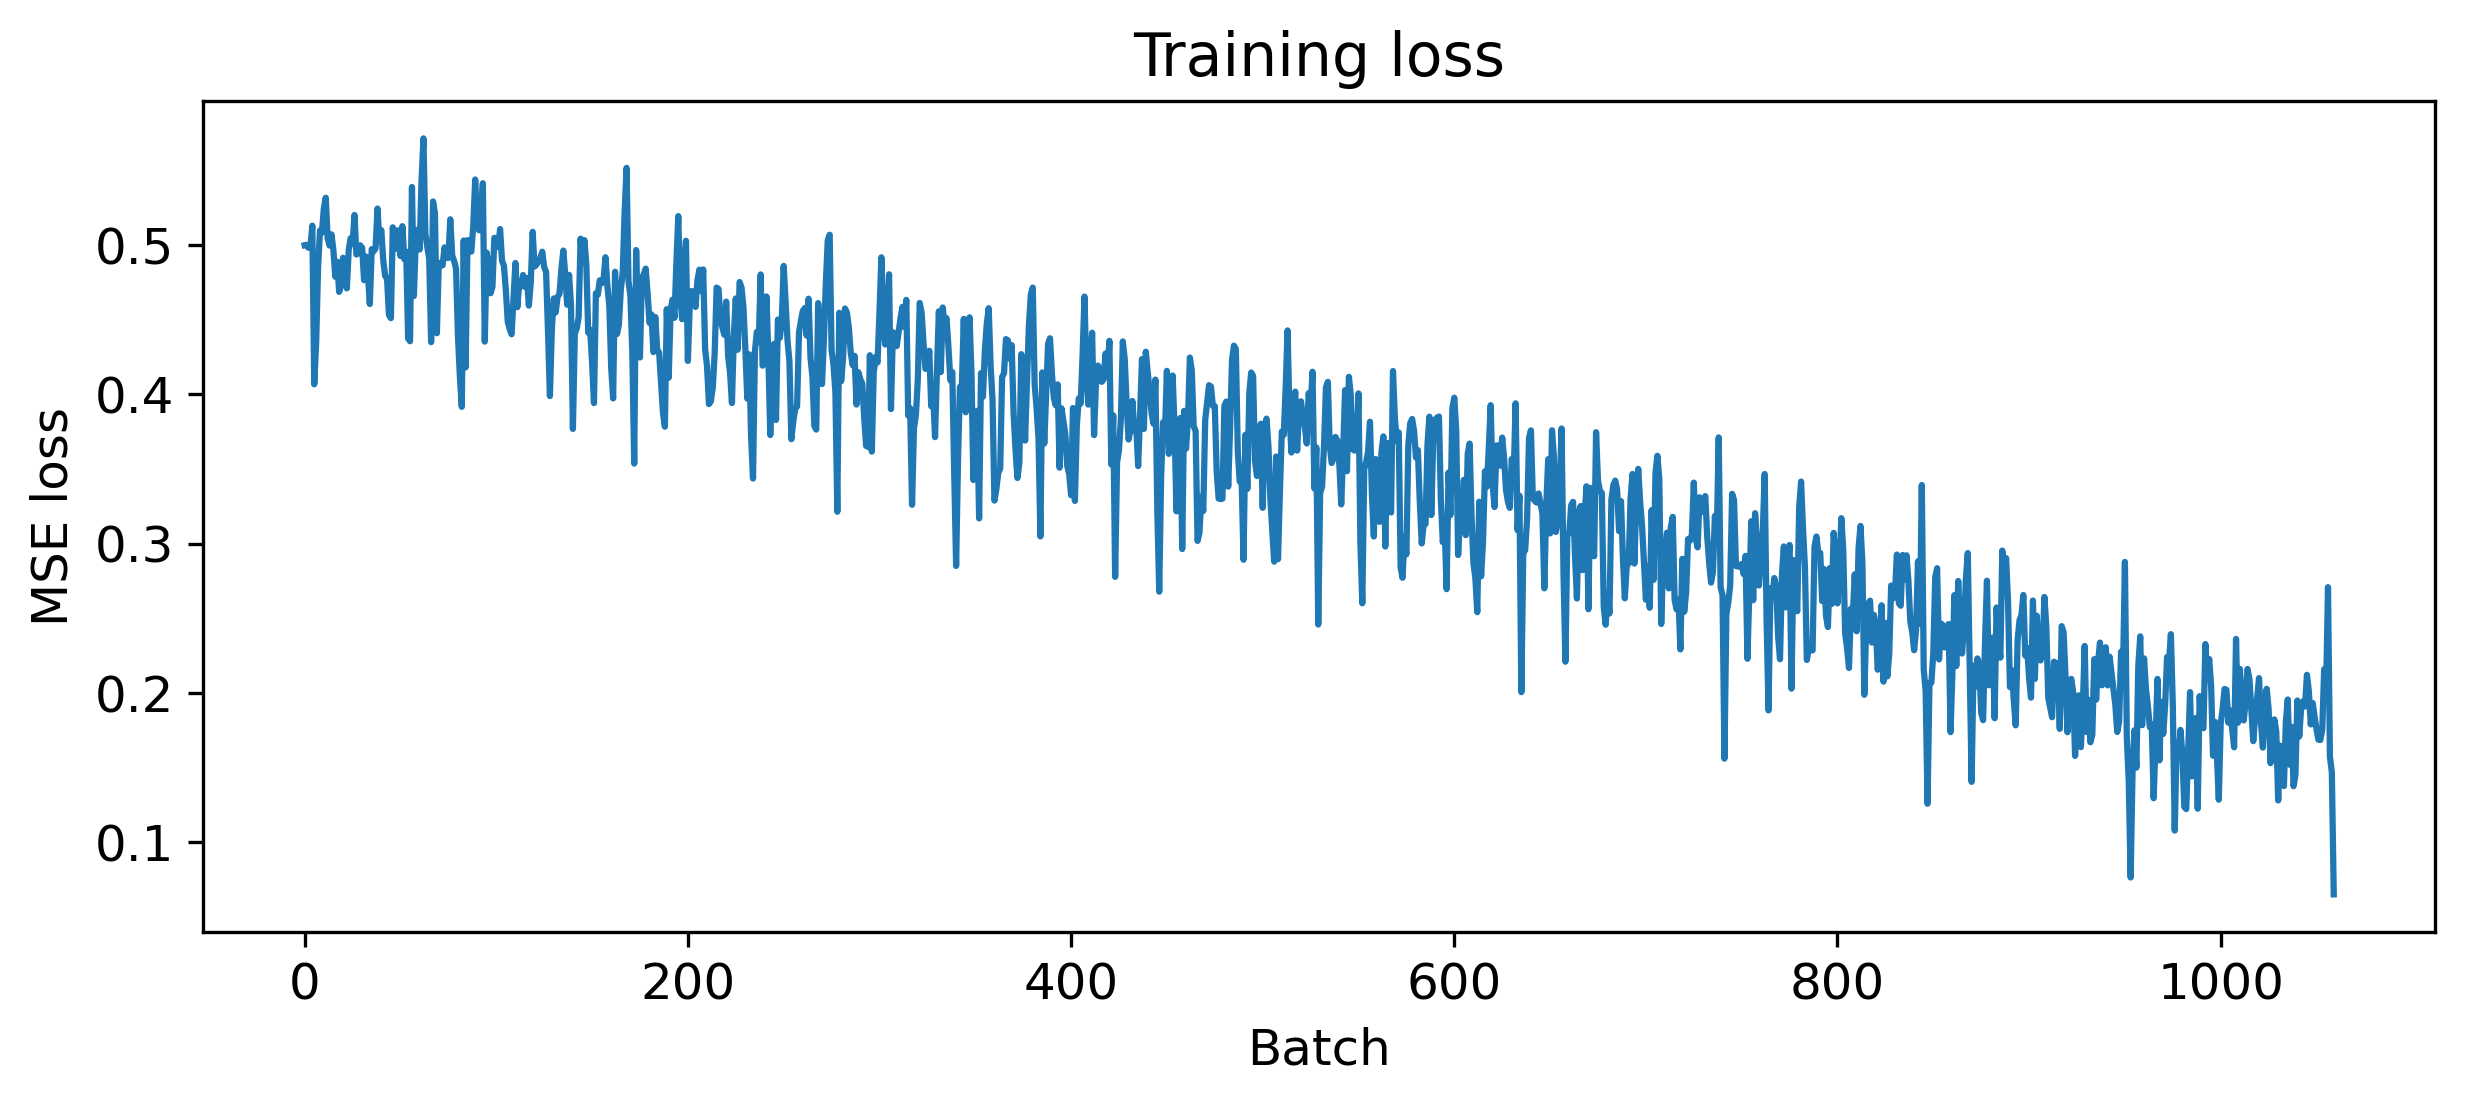

In [20]:
# - Train some epochs
num_epochs = 10

all_losses = []
epoch_losses = []
all_train_acc = []
all_test_acc = []
ep_loop = trange(num_epochs, desc='Training', unit='epoch')
history = list()
print('epoch \t train_loss \t valid_loss \t train_acc \t valid_acc')
print('-------------------------------------------------------------------')

for epoch in ep_loop:
  ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
  losses, train_loss, train_acc = train(snn.to(device), device, loader_train, optimizer)
  all_losses.extend(losses)
  all_train_acc.append(train_acc)

  history.append({'epoch': epoch, 'train_loss': train_loss,})
  # - Get test loss and accuracy
  test_loss, test_acc = test(snn.to(device), device, loader_test)
  all_test_acc.append(test_acc)
  print(f'{epoch} \t {train_loss:0.4f} \t {test_loss:0.4f}  \t {train_acc:0.4f} \t {test_acc:0.4f}')

  epoch_losses.append(test_loss)


plt.plot(all_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Training loss');

Final test loss 0.014829115434126421, accuracy 55.208333333333336%


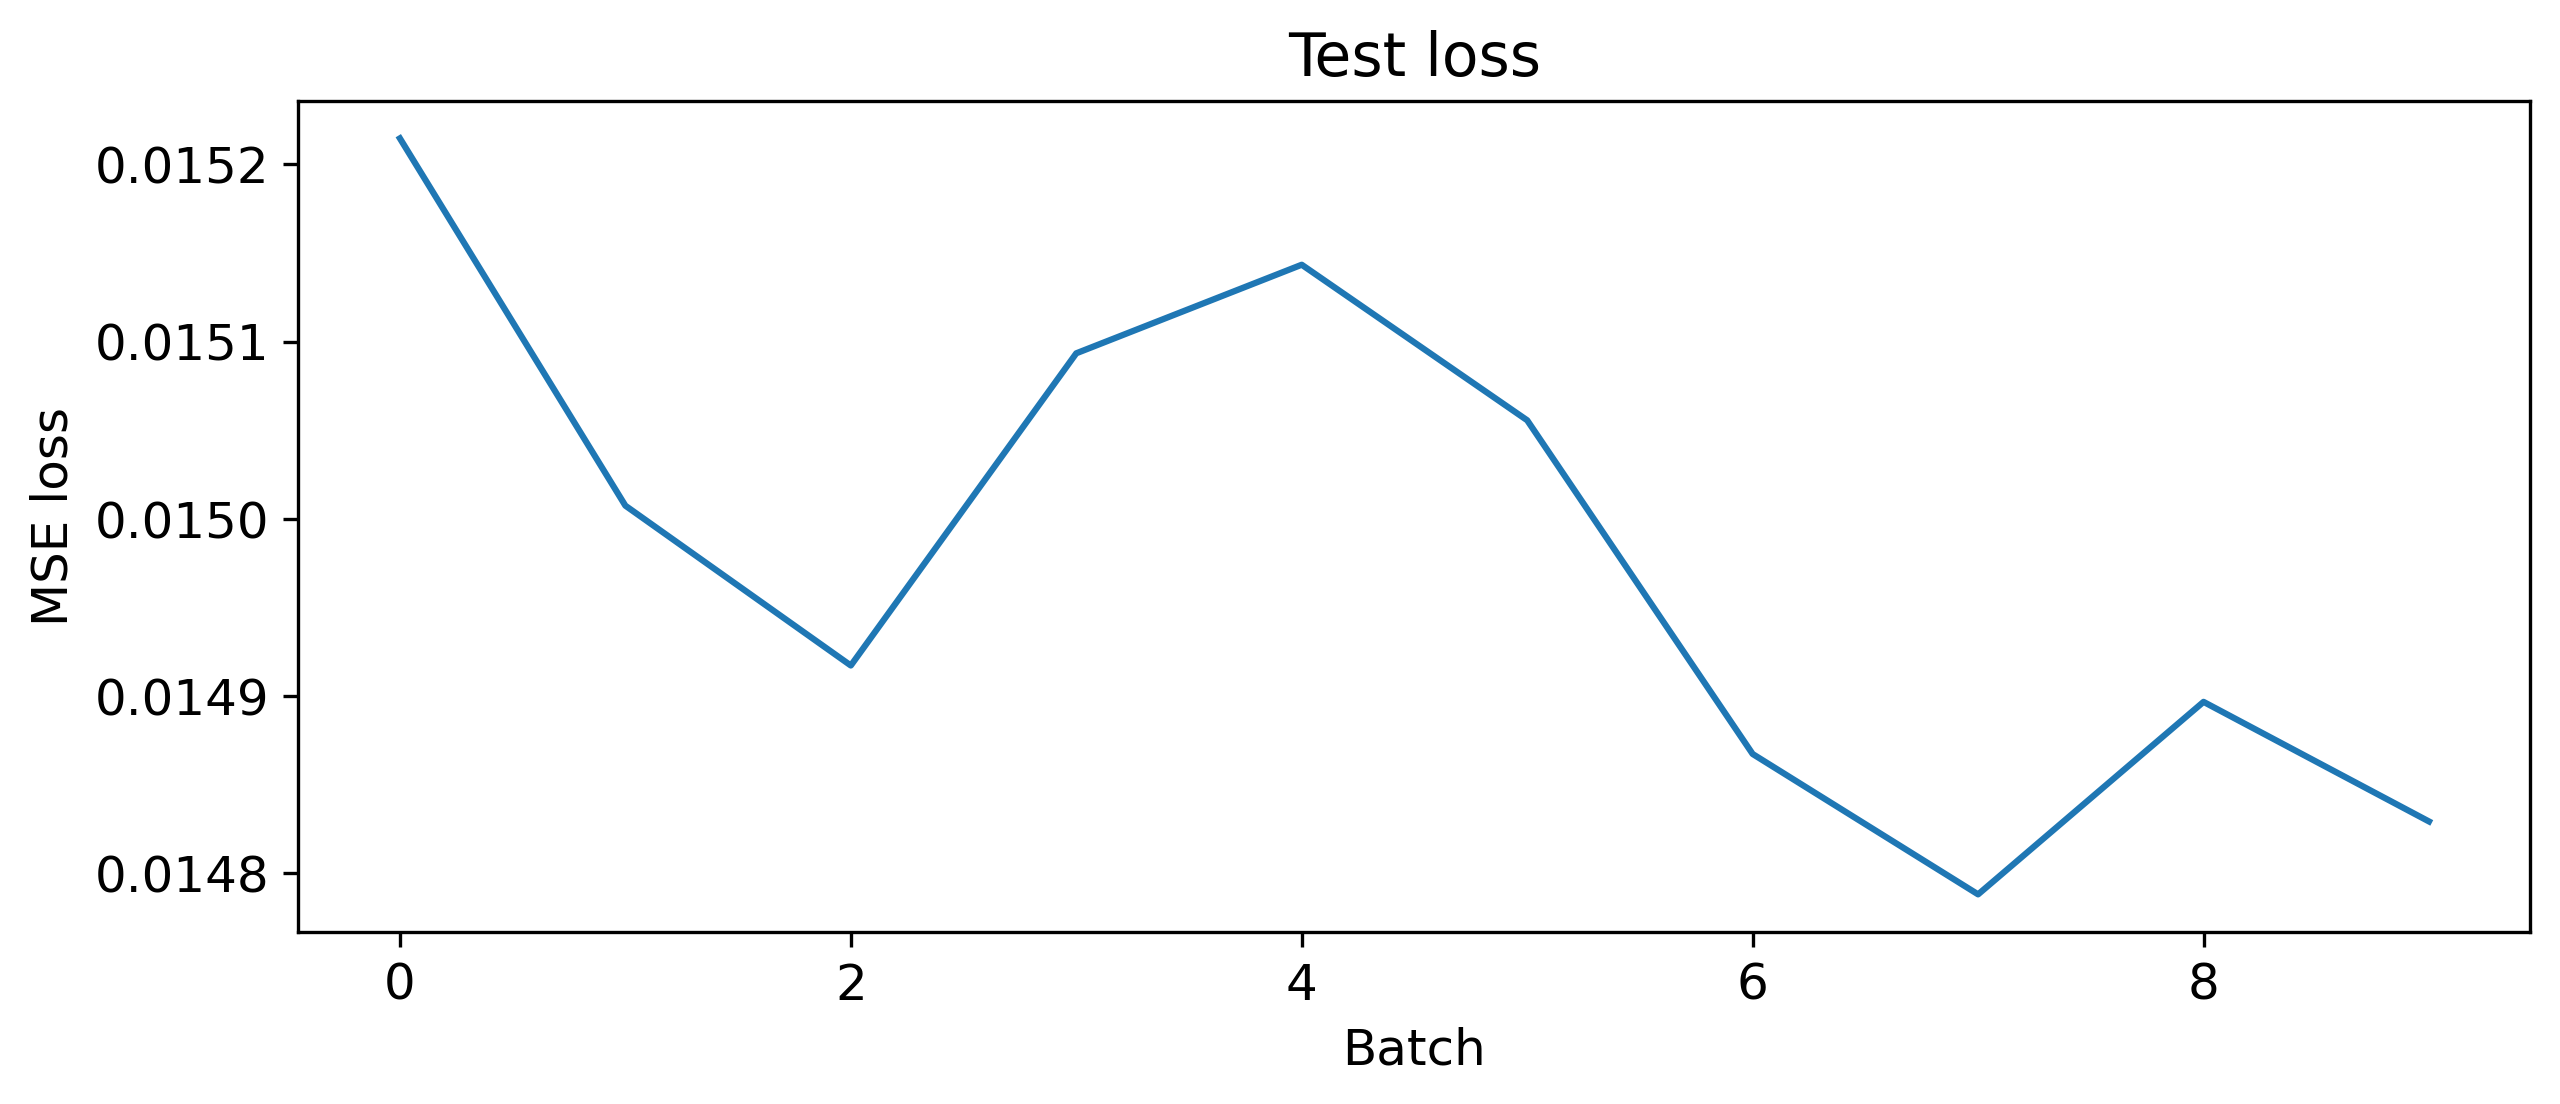

In [21]:
# - Trained loss and accuracy
plt.plot(epoch_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Test loss');
print(f'Final test loss {test_loss}, accuracy {test_acc}%')

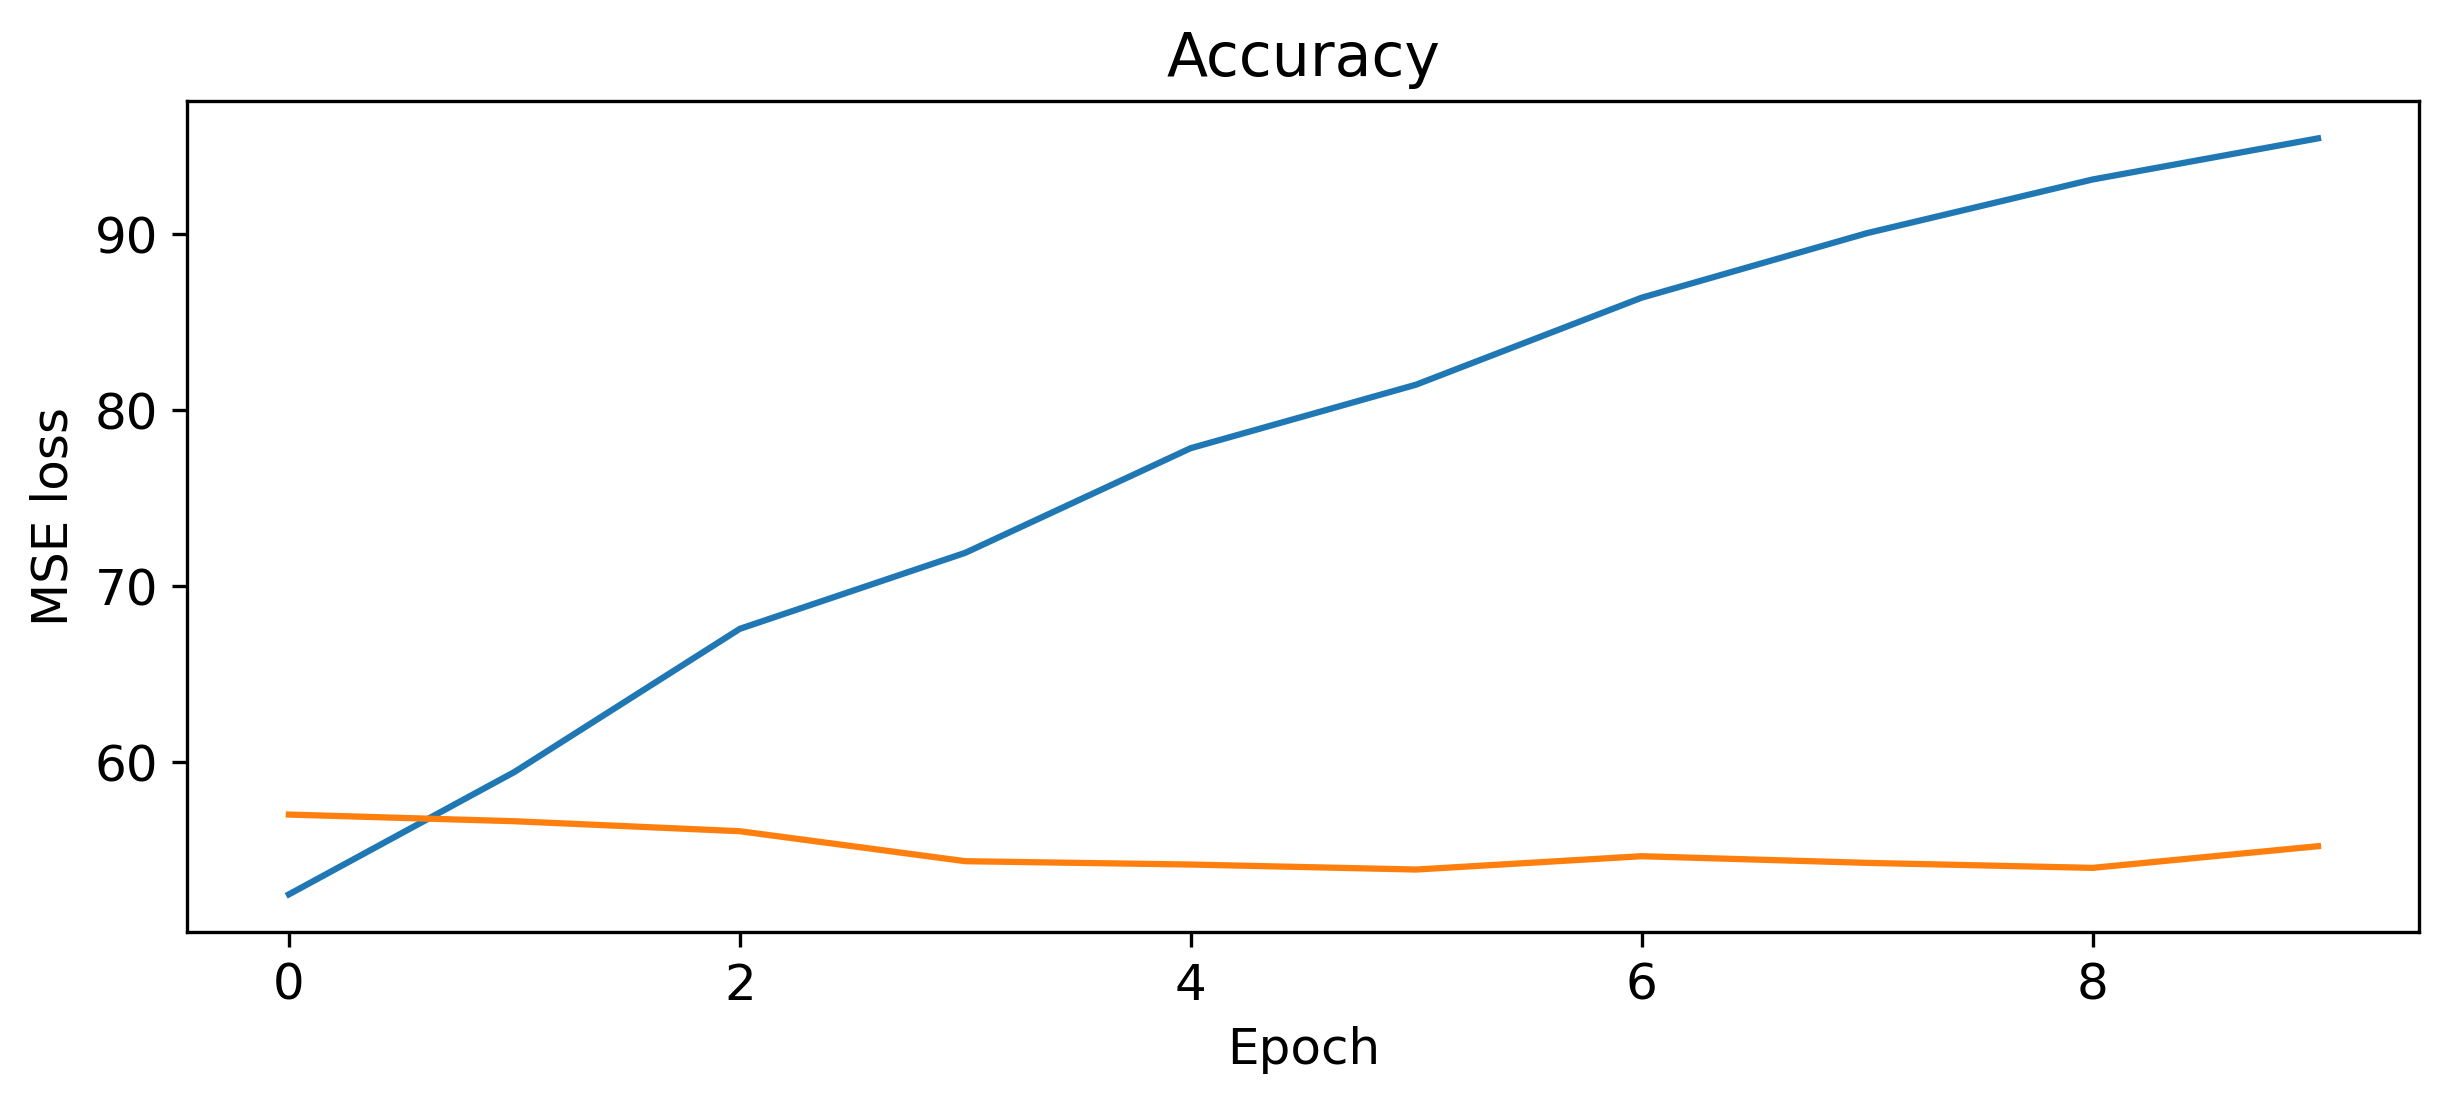

In [22]:
plt.plot(all_train_acc)
plt.plot(all_test_acc)
plt.xlabel('Epoch')
plt.ylabel('%')
plt.title('Accuracy');